In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import rasterio

# Example: Find all output rasters in the outputs folder
output_dir = "./outputs"
patterns = [
    "flin_*.tif",
    "time_of_arrival_*.tif",
    "vs_*.tif"
]

for pattern in patterns:
    for filepath in glob.glob(f"{output_dir}/{pattern}"):
        with rasterio.open(filepath) as src:
            data = src.read(1)
            print(f"{filepath}: shape={data.shape}, min={data.min()}, max={data.max()}")

./outputs/flin_0000001_0022380.tif: shape=(128, 128), min=-9999.0, max=-9999.0
./outputs/flin_0000001_0022105.tif: shape=(123, 123), min=-9999.0, max=2275.94482421875
./outputs/time_of_arrival_0000001_0022380.tif: shape=(128, 128), min=-9999.0, max=-9999.0
./outputs/time_of_arrival_0000001_0022105.tif: shape=(123, 123), min=-9999.0, max=22104.626953125
./outputs/vs_0000001_0022105.tif: shape=(123, 123), min=-9999.0, max=249.99993896484375
./outputs/vs_0000001_0022380.tif: shape=(128, 128), min=-9999.0, max=-9999.0


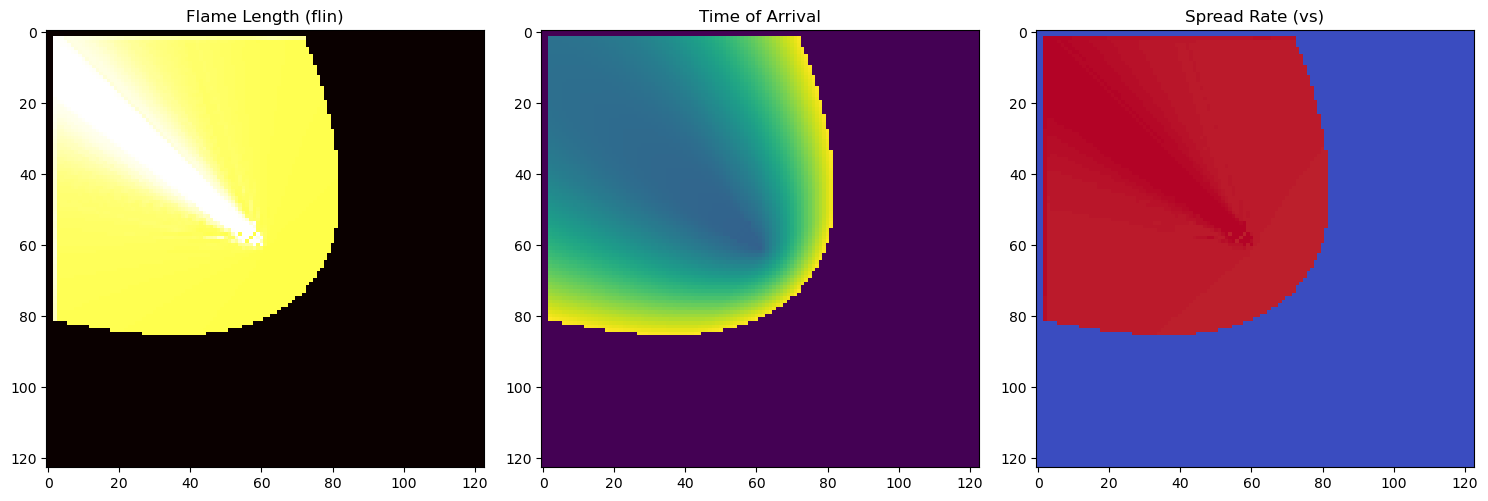

In [11]:
# plot the three rasters
flin_files = glob.glob(f"{output_dir}/flin_*.tif")
time_files = glob.glob(f"{output_dir}/time_of_arrival_*.tif")
vs_files = glob.glob(f"{output_dir}/vs_*.tif")

if flin_files and time_files and vs_files:
    flin_file = flin_files[0]
    time_file = time_files[0]
    vs_file = vs_files[0]

    with rasterio.open(flin_file) as src:
        flin_data = src.read(1)
    
    with rasterio.open(time_file) as src:
        time_data = src.read(1)
    
    with rasterio.open(vs_file) as src:
        vs_data = src.read(1)

    # Plotting the rasters
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(flin_data, cmap='hot')
    axs[0].set_title('Flame Length (flin)')
    
    axs[1].imshow(time_data, cmap='viridis')
    axs[1].set_title('Time of Arrival')
    
    axs[2].imshow(vs_data, cmap='coolwarm')
    axs[2].set_title('Spread Rate (vs)')
    
    plt.tight_layout()
    plt.show()
else:
    print("One or more output files not found. Please check the output directory and file patterns.")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

# Configuration - update these paths
output_dir = "./outputs"  # Change to your simulation directory

# File paths
flin_file = os.path.join(output_dir, f"flin_*.tif")
time_file = os.path.join(output_dir, f"time_of_arrival_*.tif")
vs_file = os.path.join(output_dir, f"vs_*.tif")

def read_and_clean_raster(filepath):
    """Read raster and handle nodata values"""
    with rasterio.open(filepath) as src:
        data = src.read(1)
        # Replace nodata with NaN
        data = np.where(data == -9999, np.nan, data)
        return data, src.meta

print("=== ELMFIRE Output Quick Check ===\n")

# Check if files exist
files_to_check = [
    ("Fire Line Intensity", flin_file),
    ("Time of Arrival", time_file), 
    ("Spread Velocity", vs_file)
]

available_files = []
for name, filepath in files_to_check:
    if os.path.exists(filepath):
        print(f"✅ {name}: Found")
        available_files.append((name, filepath))
    else:
        print(f"❌ {name}: Not found - {filepath}")

if not available_files:
    print("\n❌ No output files found! Check your paths.")
else:
    print(f"\n📊 Reading {len(available_files)} raster files...\n")
    
    # Create plots
    fig, axes = plt.subplots(1, len(available_files), figsize=(5*len(available_files), 4))
    if len(available_files) == 1:
        axes = [axes]  # Make it iterable for single plot
    
    for i, (name, filepath) in enumerate(available_files):
        # Read data
        data, meta = read_and_clean_raster(filepath)
        
        # Print statistics
        print(f"=== {name.upper()} ===")
        print(f"Shape: {data.shape}")
        print(f"Min: {np.nanmin(data):.2f}")
        print(f"Max: {np.nanmax(data):.2f}")
        print(f"Mean: {np.nanmean(data):.2f}")
        print(f"Valid pixels: {np.sum(~np.isnan(data))}")
        print()
        
        # Plot
        ax = axes[i]
        
        # Choose colormap based on variable
        if 'flin' in filepath.lower():
            # Fire line intensity - use log scale and hot colors
            data_plot = np.log10(np.maximum(data, 1))  # Avoid log(0)
            im = ax.imshow(data_plot, cmap='hot', origin='lower')
            ax.set_title(f'{name}\n(log scale)')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('log10(FLIN)')
        elif 'time' in filepath.lower():
            # Time of arrival - use plasma colors
            im = ax.imshow(data, cmap='plasma', origin='lower')
            ax.set_title(f'{name}')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Time (seconds)')
        elif 'vs' in filepath.lower():
            # Spread velocity - use coolwarm colors
            im = ax.imshow(data, cmap='viridis', origin='lower')
            ax.set_title(f'{name}')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Velocity (m/min)')
        
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate burned area
    if any('time' in fp for _, fp in available_files):
        time_data, _ = read_and_clean_raster(time_file)
        burned_pixels = np.sum(~np.isnan(time_data))
        burned_area_acres = (burned_pixels * 30 * 30) / 4047  # 30m pixels to acres
        print(f"🔥 Burned Area: {burned_area_acres:.1f} acres ({burned_pixels} pixels)")
    
    print("\n✅ Analysis complete!")

=== ELMFIRE Output Quick Check ===

❌ Fire Line Intensity: Not found - ./outputs/flin_*.tif
❌ Time of Arrival: Not found - ./outputs/time_of_arrival_*.tif
❌ Spread Velocity: Not found - ./outputs/vs_*.tif

❌ No output files found! Check your paths.


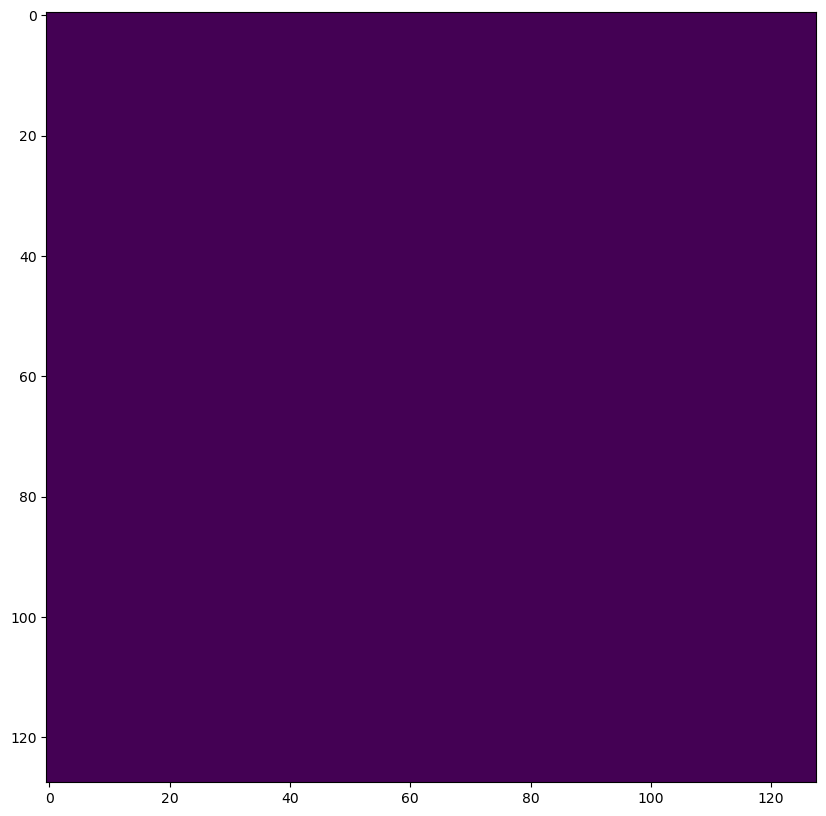

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

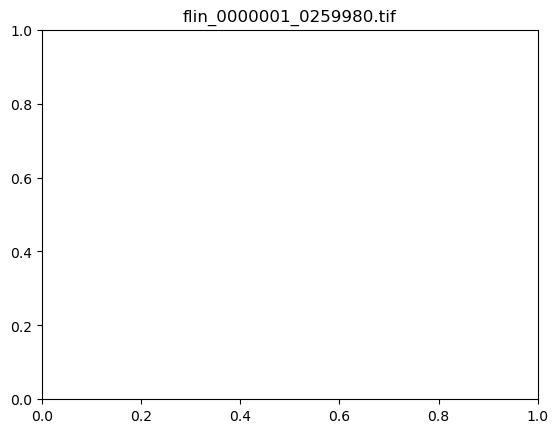

In [3]:
outpus_dir = './outputs'
# from output directory read these rasters flin_0000001_0259980.tif,
# time_of_arrival_0000001_0259980.tif, vs_0000001_0259980.tif
rasters = [
    'flin_0000001_0259980.tif',
    'time_of_arrival_0000001_0259980.tif',
    'vs_0000001_0259980.tif'
]
for raster in rasters:
    raster_path = os.path.join(outpus_dir, raster)
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        plt.figure(figsize=(10, 10))
        show(data, cmap=cm.viridis)
        plt.title(raster)
        plt.colorbar()
        plt.show()
        print(f"Raster {raster} has shape {data.shape} and dtype {data.dtype}")
        print(f"Raster {raster} has min {data.min()} and max {data.max()}")
        print(f"Raster {raster} has no data value {src.nodata}")